# A1_2 – Manual Backpropagation Neural Network (Experiments)

In this notebook we:

- Load the preprocessed and encoded datasets (`./data`).
- Run all the experiments with different neural network hyperparameters
  (number of hidden layers, activation function, learning rate, momentum, epochs).
- Compare the experiments using:
  - MSE, MAE and MAPE on train+validation (80%) and test (20%).
- Select one configuration as the "best" manual BP model,
  which will later be compared against MLR and PyTorch in a separate notebook.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sys
sys.path.append("../models")

from NeuralNet import NeuralNet # custom BP implementation (from scratch)

from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:

# Load preprocessed data from ./data

X_trainval_np = np.load("../data/X_trainval_np.npy")
X_test_np     = np.load("../data/X_test_np.npy")

y_trainval = np.load("../data/y_trainval.npy")
y_test     = np.load("../data/y_test.npy")

y_trainval_scaled = np.load("../data/y_trainval_scaled.npy")
y_test_scaled     = np.load("../data/y_test_scaled.npy")

x_scaler = joblib.load("../data/x_scaler.joblib")
y_scaler = joblib.load("../data/y_scaler.joblib")

n_features = X_trainval_np.shape[1]
print("Loaded preprocessed data from ./data")
print("X_trainval_np:", X_trainval_np.shape)
print("X_test_np    :", X_test_np.shape)
print("n_features   :", n_features)



Loaded preprocessed data from ./data
X_trainval_np: (1200, 61)
X_test_np    : (300, 61)
n_features   : 61


In [4]:
def predict_batch(model, X):
    """
    Run model.predict on each sample in X and stack results as a column vector.

    This is useful for the manual NeuralNet implementation,
    which usually expects a single sample as input to predict().
    """
    return np.array([model.predict(x) for x in X]).reshape(-1, 1)


def mape(y_true, y_pred):
    """
    Safe MAPE implementation (ignores zero targets).

    MAPE = Mean Absolute Percentage Error (in %).
    """
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0


In [6]:
def run_experiment(hidden_layers, epochs, lr, momentum,
                   activation='tanh', val_split=0.2):
    """
    Runs one BP experiment on the Bike Sharing data using the custom NeuralNet.

    Outside the NeuralNet class:
      - We split the dataset into:
            80% -> train+validation (X_trainval_np, y_trainval_scaled)
            20% -> test           (X_test_np, y_test_scaled)

    Inside the NeuralNet class:
      - val_split controls the percentage of validation inside the 80%.
      - The class automatically shuffles and splits the 80% into:
            (1 - val_split) -> internal training
            val_split       -> internal validation

    This function:
      - trains the network on the 80% (with internal train/val),
      - computes predictions on the 80% and on the 20% test,
      - returns metrics in the original target scale (cnt_log).
    """

    # Build full layer structure: [input, hidden..., output]
    layers = [n_features] + hidden_layers + [1]

    # Initialize and train network
    net = NeuralNet(
        n=layers,
        fact=activation,
        eta=lr,
        alpha=momentum,
        epochs=epochs,
        val_split=val_split
    )

    # Train on the 80% (network internally splits into train/val)
    net.fit(X_trainval_np, y_trainval_scaled)

    # Error evolution per epoch (from NeuralNet)
    train_err, val_err = net.loss_epochs()

    # Predictions in scaled space 
    y_trainval_pred_scaled = predict_batch(net, X_trainval_np)
    y_test_pred_scaled     = predict_batch(net, X_test_np)

    # Back to original target scale (cnt_log) 
    y_trainval_pred = y_scaler.inverse_transform(y_trainval_pred_scaled).ravel()
    y_test_pred     = y_scaler.inverse_transform(y_test_pred_scaled).ravel()

    # Metrics (in original cnt_log scale)
    trainval_mse  = mean_squared_error(y_trainval, y_trainval_pred)
    test_mse      = mean_squared_error(y_test, y_test_pred)

    trainval_mae  = mean_absolute_error(y_trainval, y_trainval_pred)
    test_mae      = mean_absolute_error(y_test, y_test_pred)

    trainval_mape = mape(y_trainval, y_trainval_pred)
    test_mape     = mape(y_test, y_test_pred)

    res = {
        "model": net,
        "train_err": train_err,
        "val_err": val_err,
        "Number of layers": len(layers),
        "Layer Structure": layers,
        "Num epochs": epochs,
        "Learning Rate": lr,
        "Momentum": momentum,
        "Activation function": activation,

        # Metrics on the 80% (train+val combined)
        "TRAINVAL_MSE": trainval_mse,
        "TRAINVAL_MAE": trainval_mae,
        "TRAINVAL_MAPE": trainval_mape,

        # Metrics on the 20% test set
        "TEST_MSE": test_mse,
        "TEST_MAE": test_mae,
        "TEST_MAPE": test_mape,
    }

    return res


In [7]:
# Hyperparameter configurations  - Here we'll add all the experiments we want. Target for the activity is to do at least 10
hyperparams_list = [

    #  1: One Layer tanh 
    {
        "hidden_layers": [20],
        "epochs": 400,
        "lr": 0.005,
        "momentum": 0.5,
        "activation": "tanh"
    },

    #  2: Deep tanh 
    {
        "hidden_layers": [40, 15],
        "epochs": 600,
        "lr": 0.005,
        "momentum": 0.9,
        "activation": "tanh"
    },

    #  3: One Layer sigmoid 
    {
        "hidden_layers": [20],
        "epochs": 400,
        "lr": 0.005,
        "momentum": 0.5,
        "activation": "sigmoid"
    },

    #  4: Deep ReLU 
    {
        "hidden_layers": [40, 15],
        "epochs": 600,
        "lr": 0.005,
        "momentum": 0.9,
        "activation": "relu"
    },
]


In [8]:
all_results = []

for i, cfg in enumerate(hyperparams_list, start=1):
    print("\n====================================")
    print(f"Running Experiment {i}")
    print("Config:", cfg)
    print("====================================")

    res = run_experiment(
        hidden_layers=cfg["hidden_layers"],
        epochs=cfg["epochs"],
        lr=cfg["lr"],
        momentum=cfg["momentum"],
        activation=cfg["activation"],
        val_split=0.2      # keep same val_split for all
    )

    res["Experiment"] = i
    all_results.append(res)

# Build a DataFrame with the most important fields
cols = [
    "Experiment",
    "Number of layers",
    "Layer Structure",
    "Num epochs",
    "Learning Rate",
    "Momentum",
    "Activation function",
    "TRAINVAL_MSE", "TRAINVAL_MAE", "TRAINVAL_MAPE",
    "TEST_MSE", "TEST_MAE", "TEST_MAPE",
]

results_df = pd.DataFrame(all_results)[cols]

print("\n=== Summary of all manual BP experiments ===")
display(results_df)



Running Experiment 1
Config: {'hidden_layers': [20], 'epochs': 400, 'lr': 0.005, 'momentum': 0.5, 'activation': 'tanh'}
Neural network has been initialized
Architecture (neurons per layer): [61, 20, 1]
Activation function used: tanh
 Layer 1: w(20, 61), theta(20, 1)
 Layer 2: w(1, 20), theta(1, 1)
Epoch 0: Train MSE=0.112088 | Val MSE=0.066350
Epoch 100: Train MSE=0.003325 | Val MSE=0.029981
Epoch 200: Train MSE=0.001375 | Val MSE=0.034901
Epoch 300: Train MSE=0.000825 | Val MSE=0.038111

Running Experiment 2
Config: {'hidden_layers': [40, 15], 'epochs': 600, 'lr': 0.005, 'momentum': 0.9, 'activation': 'tanh'}
Neural network has been initialized
Architecture (neurons per layer): [61, 40, 15, 1]
Activation function used: tanh
 Layer 1: w(40, 61), theta(40, 1)
 Layer 2: w(15, 40), theta(15, 1)
 Layer 3: w(1, 15), theta(1, 1)
Epoch 0: Train MSE=0.107287 | Val MSE=0.048276
Epoch 100: Train MSE=0.000253 | Val MSE=0.019280
Epoch 200: Train MSE=0.000094 | Val MSE=0.018208
Epoch 300: Train MS

,Experiment,Number of layers,Layer Structure,Num epochs,Learning Rate,Momentum,Activation function,TRAINVAL_MSE,TRAINVAL_MAE,TRAINVAL_MAPE,TEST_MSE,TEST_MAE,TEST_MAPE
0,1,3,"[61, 20, 1]",400,0.005,0.5,tanh,0.035276,0.098228,3.046734,0.150001,0.272670,10.053414
1,2,4,"[61, 40, 15, 1]",600,0.005,0.9,tanh,0.013585,0.035267,1.500460,0.083991,0.133406,7.255068
2,3,3,"[61, 20, 1]",400,0.005,0.5,sigmoid,0.032820,0.113533,3.513376,0.100645,0.202705,8.401143
3,4,4,"[61, 40, 15, 1]",600,0.005,0.9,relu,0.024588,0.089806,2.687140,0.124717,0.222161,9.435912


In [9]:

# Select the experiment to use the configuration for the graphs
chosen_experiment = 1   # Detail here the Experiment number
chosen_idx = results_df.index[results_df["Experiment"] == chosen_experiment][0]

print("\nUsing experiment", chosen_experiment, "as the selected configuration.")

best_res = all_results[chosen_idx]
best_model = best_res["model"]
best_train_err = best_res["train_err"]
best_val_err = best_res["val_err"]



Using experiment 1 as the selected configuration.


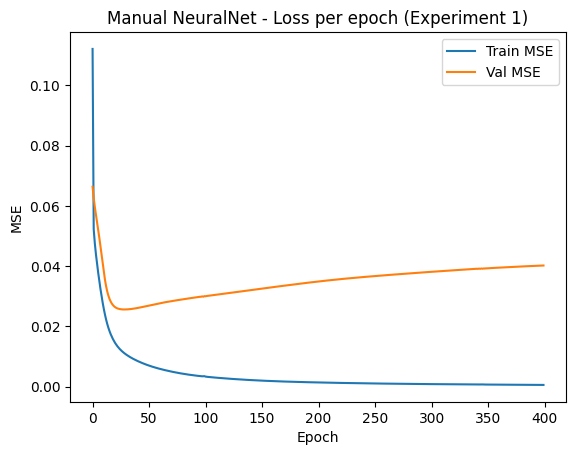

In [10]:

# Loss curves for the selected experiment


plt.figure()
plt.plot(best_train_err, label="Train MSE")
if any(e is not None for e in best_val_err):
    plt.plot([e for e in best_val_err if e is not None], label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title(f"Manual NeuralNet - Loss per epoch (Experiment {chosen_experiment})")
plt.legend()
plt.show()


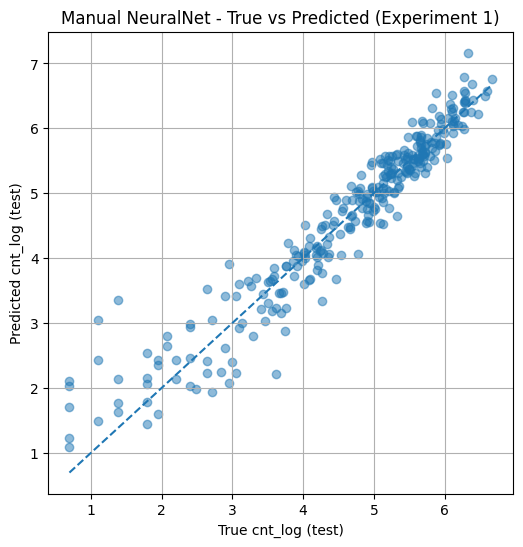

In [11]:

# Scatter plot: true vs predicted on TEST set


# Predictions in scaled space
y_test_pred_scaled = predict_batch(best_model, X_test_np)

# Back to original target scale
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled).ravel()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel("True cnt_log (test)")
plt.ylabel("Predicted cnt_log (test)")
plt.title(f"Manual NeuralNet - True vs Predicted (Experiment {chosen_experiment})")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")  # ideal y = x line
plt.grid(True)
plt.show()


## Summary of manual BP experiments

In this notebook we:

- Loaded the datasets from (`../data`).
- Defined several neural network configurations for the manual BP model
  (different number of hidden units, activation functions, learning rate, momentum, epochs).
- For each configuration we trained the model and computed:
  - MSE, MAE and MAPE on the 80% (train+validation),
  - MSE, MAE and MAPE on the 20% test set.
- Collected the results in a comparison table and selected one experimentaccording to its performance on the test set.

The selected configuration will be used later to compare:

- Manual BP vs Multiple Linear Regression (MLR),
- Manual BP vs PyTorch neural network

in the next notebook: **A1_3_MLR_and_PyTorch_Comparison.ipynb**.
